# Global latency optimization for single instance deployment

## Import the libraries that are going to be used

In [1]:
import numpy as np
import pandas as pd
from mip import *
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import math
import json
from tkinter import Tk
from tkinter import filedialog

# Introduction
The swarm of drones is going to cover determined Areas Of Interest (AOI). This information can be represented easily if the AOI is divided in tiles. For each tile, if it contains a fragment of the AOI, then a drone is placed in that tile.

<div>
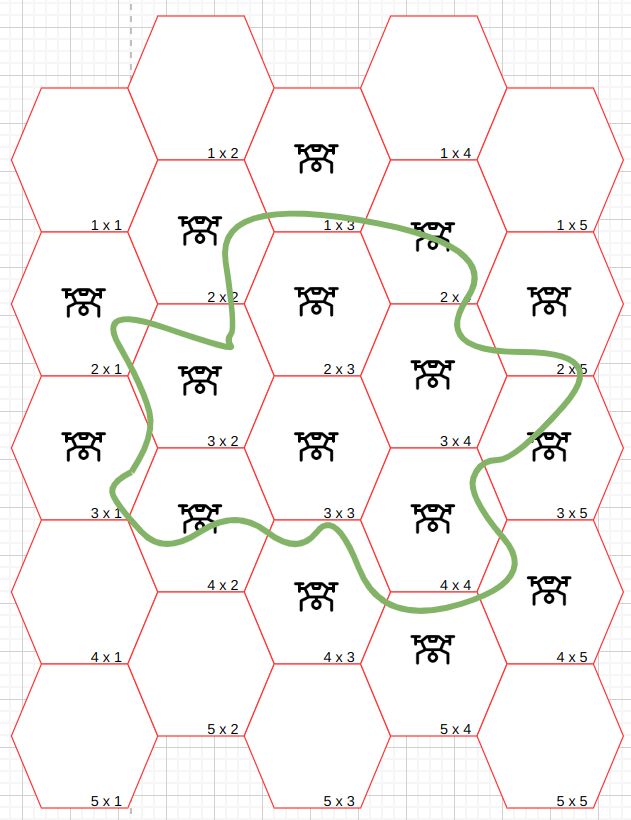
</div>

Until this point, it has been defined two parameters:

- $T = \{n,m\}$, specifies the dimensions of the scenario
- $D_{m,n} = \begin{bmatrix} d_{1,1} & d_{1,2} & ... & d_{1,m} \\ d_{2,1} & d_{2,2} & ... & d_{2,m} \\ ... \\  d_{n,1} & d_{n,2} & ... & d_{n,m} \end{bmatrix}$, specifies if there is a drone in a tile or not.

The swarm of drones is going to offer a set of microservices that the users are going to take advantage of. This microservices can be consumed in an isolated manner or as a workflow. A workflow can be described as a sequence of microservices. Been a sequence implies order and that means that the microservice $m_{i}$ of a workflow, should not be placed far away from $m_{i-1}$ because of the negative impact in the global latency due to their tight coupling. 
 At the same time, a microservice that is consumed standalone can be describe as the workflow comprised only of it. $m_{isolated} => w_{m_{isolated}} = \{m_{isolated}\}$.
- $M = \{m_{1}, m_{2}, ..., m_{k}\}$, the list of all microservices
- $W = \{w_{1}, w_{2}, ..., w_{n}\}, w_{i} = \{m_{1}, m_{j}, ..., m_{k}\}$

To enrich the problem what is going to be done is to include the notion of "the need to place a microservice, $m_{i}$, in a drone placed in a specific tile, $d_{jk}$". This information is going to be represented as a 3-D matrix that, for each microservice, indicates how much it is needed in a tile. Therefore, this solution relies in historic data or in predictions of where and how much are the workflows of the scenario going to be queried.

- $H_{i, j, k}$

This info can be visualized as a cube:

<div>
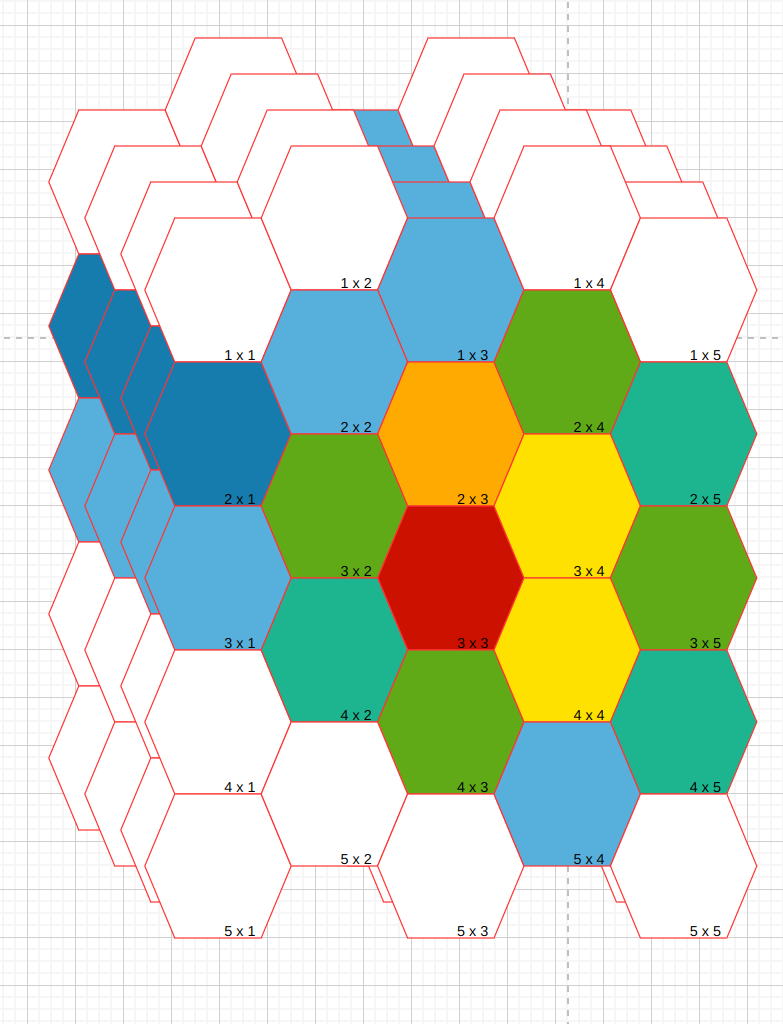
</div>

Finally, there is an important value that cuantifies the cost of each link of the swarm. This can be as a matrix where each position indicates the cost of going from tile i to tile j. The cost of those tiles that are not adjacent is $\infty$ (and if it is only wanted to cuantify the number of jumps, the rest can be 1):
- $\Gamma = \begin{bmatrix} \gamma_{1,1} & \gamma_{1,2} & ... & \gamma_{1,m*n} \\ \gamma_{2,1} & \gamma_{2,2} & ... & \gamma_{2,m*n} \\ ... \\  \gamma_{m*n,1} & \gamma_{m*n,2} & ... & \gamma_{m*n,m*n} \end{bmatrix}$

<div>
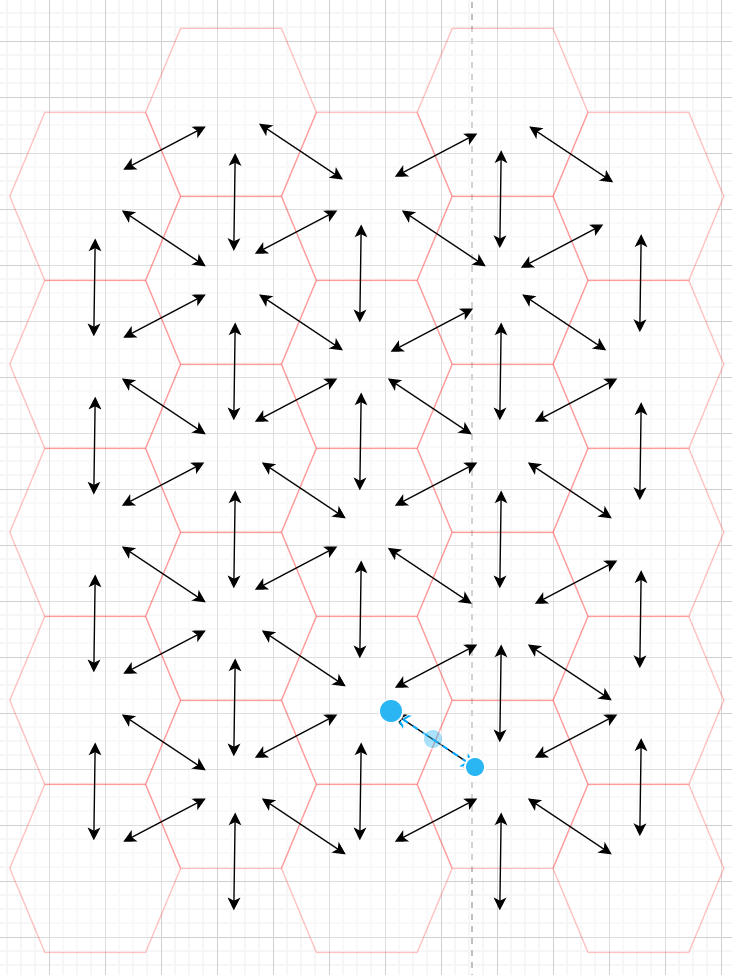
</div>



# Step 1: Define de parameters
## Load the parameters from configuration

In [2]:
isConfigLoaded = True
try:
    Tk().withdraw()
    filenames = filedialog.askopenfilenames()
    filename = filenames[0] if filenames[0] != None else r"./scenario_001.json"
    print(filenames)

    configuration = json.load(open(filename))
    
    T     = configuration["T"]
    D     = configuration["D"]
    M     = configuration["M"]
    H     = configuration["H"]
    GAMMA = configuration["GAMMA"]
    print(f'Parameters loaded from file {filename}')

except Exception as e:
    isConfigLoaded = False
    print(e)
    print('The input file was not found nor the default input file')
    print('Loading default parameters')

('/home/santiago/Documents/Trabajo/Workspace/Mathematical_Optimization/LatencyOptimization/test_003.json',)
Parameters loaded from file /home/santiago/Documents/Trabajo/Workspace/Mathematical_Optimization/LatencyOptimization/test_003.json


### Define the topology
- $T = \{n,m\}$, specifies the dimensions of the scenario
- $D_{m,n} = \begin{bmatrix} d_{1,1} & d_{1,2} & ... & d_{1,m} \\ d_{2,1} & d_{2,2} & ... & d_{2,m} \\ ... \\  d_{n,1} & d_{n,2} & ... & d_{n,m} \end{bmatrix}$, specifies if there is a drone in a tile or not.

In [3]:
if not isConfigLoaded:
    # Specify the dimension of the scenario
    m = 5
    n = 5
    T = [m, n]
    # Specify the topology of the swarm
    D = [
            [0, 0, 1, 0, 0],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [0, 1, 1, 1, 1],
            [0, 0, 0, 1, 0]
        ]

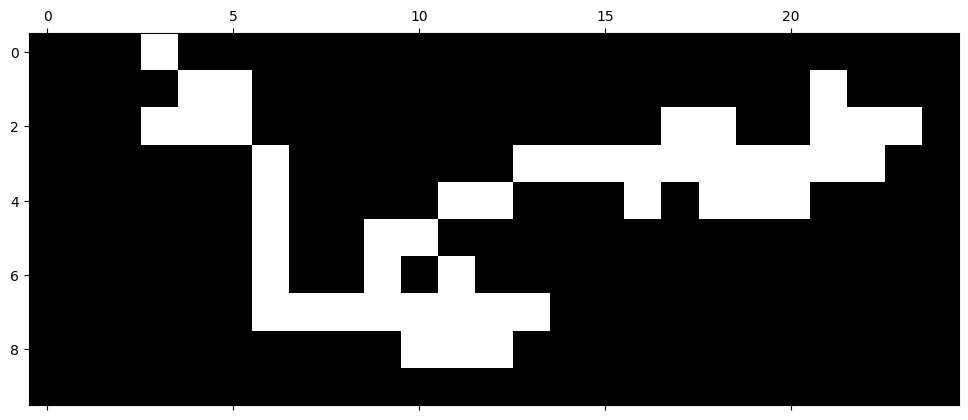

In [4]:
plt.matshow(D, cmap='binary_r')
plt.show()

### Define the list of microservices
- $M = \{m_{1}, m_{2}, ..., m_{k}\}$, the list of all microservices


In [5]:
if not isConfigLoaded:
    # Specify the list of microservices and the list of workflows
    M = ['m1', 'm2', 'm3', 'm4', 'm5']

### Define the Heatmap for each microservice
- $H_{i, j, k}$

In [6]:
if not isConfigLoaded:
    # Specify the heatmap for each microservice
    H = [
            [
                [0, 0, 1, 0, 0],
                [5, 3, 2, 1, 1],
                [2, 3, 2, 1, 1],
                [0, 1, 1, 4, 4],
                [0, 0, 0, 5, 0]
            ],
            [
                [0, 0, 3, 0, 0],
                [1, 2, 2, 2, 1],
                [1, 3, 3, 1, 1],
                [0, 4, 3, 2, 1],
                [0, 0, 0, 1, 0]
            ],
            [
                [0, 0, 3, 0, 0],
                [3, 4, 3, 2, 1],
                [3, 3, 3, 2, 1],
                [0, 2, 2, 2, 1],
                [0, 0, 0, 1, 0]      
            ],
            [
                [0, 0, 2, 0, 0],
                [2, 3, 3, 3, 1],
                [2, 3, 5, 2, 1],
                [0, 1, 2, 2, 1],
                [0, 0, 0, 1, 0]     
            ],
            [
                [0, 0, 3, 0, 0],
                [4, 4, 1, 1, 1],
                [5, 1, 1, 4, 4],
                [0, 1, 1, 4, 5],
                [0, 0, 0, 1, 0]
            ]

        ]

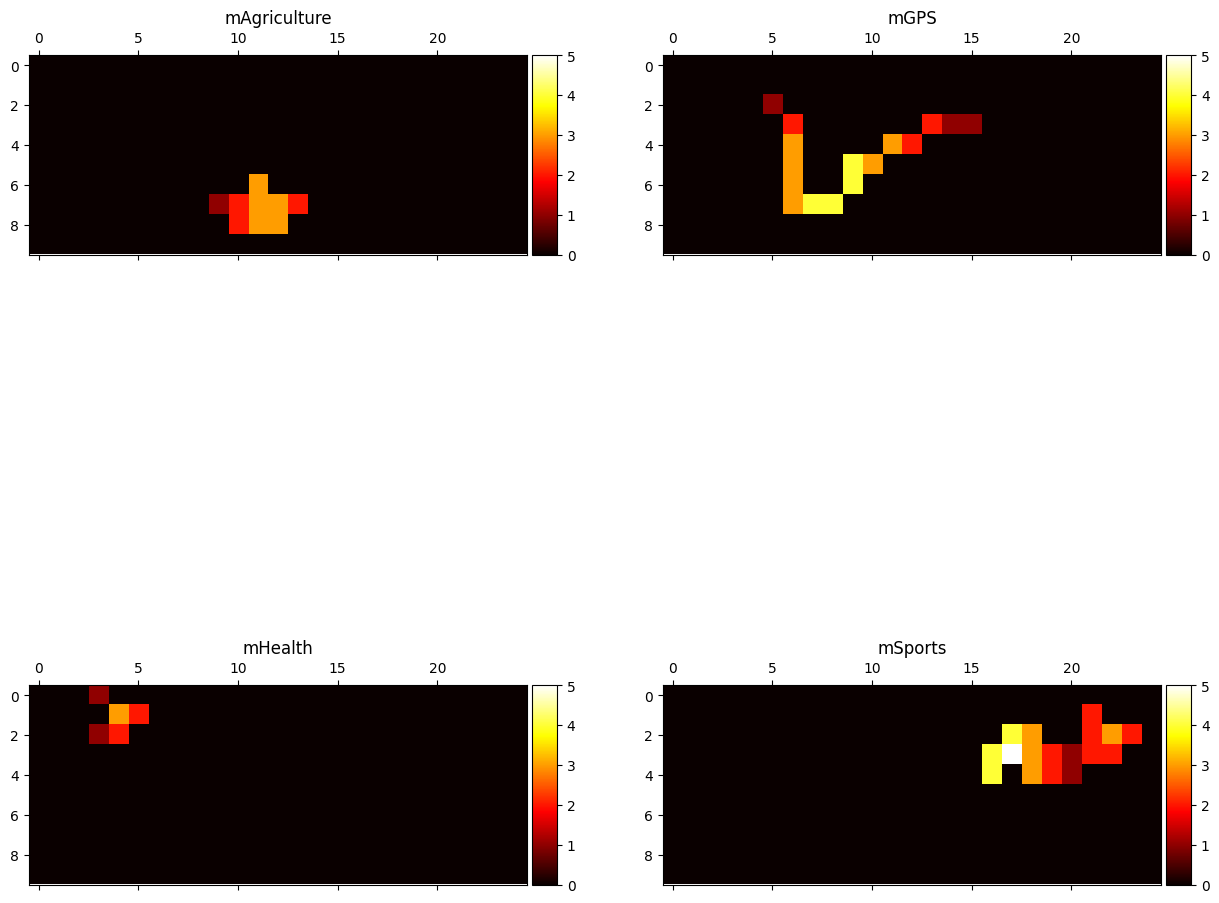

In [7]:
# Visualization of the heatmaps
rows = math.ceil(len(H[:])/2)
fig, ax = plt.subplots(rows, 2, figsize=(15, 15))
for heatmap, i in zip(H[:], range(len(H[:]))):
    ax[i//2][i%2].title.set_text(M[i])
    mat_img = ax[i//2][i%2].matshow(heatmap, cmap="hot", vmin = 0, vmax= np.amax(H))
    divider = make_axes_locatable(ax[i//2][i%2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(mat_img, cax=cax)
if (len(H[:]) % 2 == 1): fig.delaxes(ax[-1][-1])
plt.show()

### Define the cost of each route
- $\Gamma = \begin{bmatrix} \gamma_{1,1} & \gamma_{1,2} & ... & \gamma_{1,m*n} \\ \gamma_{2,1} & \gamma_{2,2} & ... & \gamma_{2,m*n} \\ ... \\  \gamma_{m*n,1} & \gamma_{m*n,2} & ... & \gamma_{m*n,m*n} \end{bmatrix}$

# Step 2: Define the decision variables
The decision variable is the 3-D matrix that specifies if a microservice, $m_{i}$ is deployed in a dron located in a specific tile $d_{j, k}$:
- $S_{i,j,k}$

In [8]:
m = Model(sense=MAXIMIZE, solver_name=CBC)
m.threads = -1 # Use all cores Available

for microservice in M:
    for i in range(T[0]):
        for j in range(T[1]):
            m.add_var(f"s_{microservice},d{i},{j}", var_type=BINARY)

decision_variables = np.array(m.vars)
print(decision_variables.shape)
None

(1000,)


# Step 3: Define the set of restrictions
The restrictions are the hardware limitations of each of the drones and that each microservice has to be deployed at least once.
## Restrictions 3.1: 
The services deployed in a tile cannot surpass the capacity of the drone deployed there.
- $\sum \limits _{i=1} ^{M} s_{i,j,k} <= capacity_{d_{jk}}$


In [9]:
decision_variables_aux = decision_variables.reshape((len(M), -1)).T

for i in range(decision_variables_aux.shape[0]):
    
    constraint = xsum(decision_variables_aux[i]) <= D[i//T[1]][i%T[1]]
    m.add_constr(constraint, name=f'Capacity of d_{i//len(M)}{i%len(M)} not surpased')

None

## Restriction 3.2: 
Each microservice must be deployed at least once:
- $\sum \limits _{j=1} ^{m} \sum \limits _{k=1} ^{n} s_{i,j,k} >= 1$

In [10]:
decision_variables_aux = decision_variables.reshape((len(M),-1))
for i in range(len(M)):
    # constraint = xsum(decision_variables_aux[i]) >= 1
    constraint = xsum(decision_variables_aux[i]) == 1
    m.add_constr(constraint, name=f'Microservice {M[i]} deployed')


# Step 4: Define the objective function
The objective is to reduce the cost from going from a tile where a workflow is requested to the tiles where the the microservices of the workflow can be served:

$$minimize(\sum \limits _{i = 1} ^{m} \sum \limits _{j = 1} ^{n} d_{i,j} \cdot \sum \limits _{i' = 1} ^{m} \sum \limits _{j' = 1} ^{n} d_{i',j'} \cdot \sum \limits _{k = 1} ^{Ms} \Gamma_{(i \cdot n+j),(i' \cdot n+j')} \cdot {h_{k,i,j}} \cdot s_{k,i',j'}$$


In [11]:
def flatten(xs):
    result = []
    if isinstance(xs, (list, tuple)):
        for x in xs:
            result.extend(flatten(x))
    else:
        result.append(xs)
    return result

In [12]:
def distance(src_drone: any, dst_drone: any):
    return max(abs(src_drone['i'] - dst_drone['i']), abs(src_drone['j'] - dst_drone['j']))

def pathCost(src_drone: any, dst_drone: any, isDeployed: bool, src_heat: int, dst_heat: int):
    costFunction = D[src_drone['i']][src_drone['j']] * D[dst_drone['i']][dst_drone['j']] * isDeployed * src_heat
    costFunction *=  (distance(src_drone, dst_drone) + 1)
    # costFunction *= distance(src_drone, dst_drone)
    return  costFunction


decision_variables_aux = decision_variables.reshape((len(M), T[0], T[1]))


objective_function = 0
#for i in range(T[0]):
#    for j in range(T[1]):
#        for k in range(len(M)):
#            for ii in range(T[0]):
#                for jj in range(T[1]):            
#                    objective_function += pathCost( {'value': D[i][j],'i': i, 'j': j}, {'value': D[ii][jj],'i': ii, 'j': jj}, decision_variables_aux[k][i][j], H[k][i][j])
                    
objective_function = \
[ \
    [ D[i][j] * \
        [ \
            [  D[ii][jj] * \
                [ decision_variables_aux[k][ii][jj] * H[k][i][j] * GAMMA[i*T[1]+j][ii*T[1]+jj] \
                for k in range(len(M))] \
             for ii in range(T[0])] \
        for jj in range(T[1])] \
    for j in range(T[1])] \
for i in range (T[0])]

objective_function = xsum(flatten(objective_function))


m.objective = minimize(objective_function)


# Step 5: Execute solver and check the result
The decision variables are shown along their optimal values using a DataFrame from Pandas.

In [13]:
m.verbose = 1
status = m.optimize()
print(status)

df_data = [{"Nombre variable": var.name, "Valor optimizado": var.x} for var in m.vars]
solution_df = pd.DataFrame(df_data)

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(solution_df[solution_df['Value'] == 1])    


Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 51 (-203) rows, 188 (-812) columns and 376 (-1624) elements
Clp1000I sum of infeasibilities 2.73964e-06 - average 5.37184e-08, 170 fixed columns
Coin0506I Presolve 0 (-51) rows, 0 (-188) columns and 0 (-376) elements
Clp0000I Optimal - objective value 228
Clp0000I Optimal - objective value 228
Coin0511I After Postsolve, objective 228, infeasibilities - dual 0 (0), primal 0 (0)
Clp0000I Optimal - objective value 228
Clp0000I Optimal - objective value 228
Clp0000I Optimal - objective value 228
Coin0511I After Postsolve, objective 228, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 228 - 0 iterations time 0.002, Presolve 0.00, Idiot 0.00

Starting MIP optimization
OptimizationStatus.OPTIMAL
          Nombre variable  Valor optimizado
0     s_mAgriculture,d0,0               0.0
1     s_mAgricu

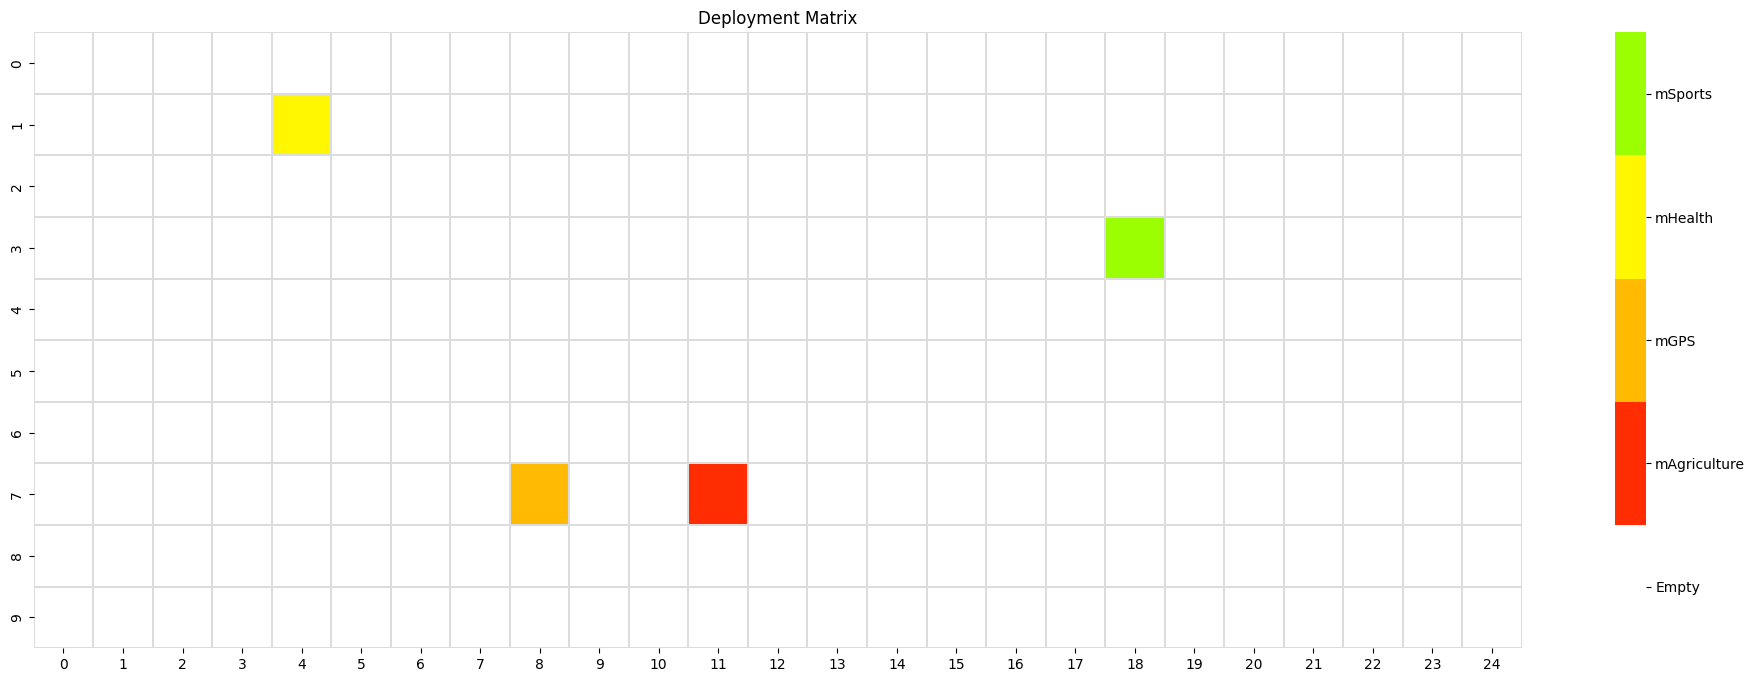

In [14]:
solution_ndarray = solution_df.to_numpy()
solution_ndarray = solution_ndarray.reshape((len(M), T[0]*T[1], -1))

deployment_matrix = solution_ndarray[:,:,1]
#print(deployment_matrix.reshape(np.shape(H)))

deployment_matrix = deployment_matrix.reshape((len(M), T[0], T[1]))
deployment_matrix = [m *(i+1) for m, i in zip(deployment_matrix[:], range(deployment_matrix.shape[0]))]
deployment_matrix = np.add.reduce(deployment_matrix[:] )
# print(deployment_matrix)

colors = ['#FFFFFF', '#FF2D01', '#FFBA01', '#FFF701', '#9BFF01', '#01FFDC', '#0184FF', '#010DFF', '#B601FF', '#FF01E0']
cmap = ListedColormap(colors[0:len(M)+1], name='from_list', N=None)

plt.figure(figsize = (24,8))
ax = sns.heatmap(deployment_matrix.astype(np.int8), cmap=cmap, linecolor='gainsboro', linewidths=.1)
plt.title('Deployment Matrix')

colorbar = ax.collections[0].colorbar
n = len(M) + 1


r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(len(M) + 1)])
colorbar.set_ticklabels(['Empty'] + M)

#deployment_matrix = [ for m in deployment_matrix[]]